## Step 1: Training a model in PyTorch
To train a model in PyTorch, you first need to define the model architecture using PyTorch's nn module. You can then load your data, define a loss function, and use an optimizer to update the model parameters during training. Here's some sample code to get you started:

We are using the MNIST dataset here just for demo

In [1]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as T

transform = T.Compose([
  T.ToTensor(),
])

root = os.path.join(os.getenv('HOME'), 'datasets', 'mnist')
train_dataset = MNIST(root, train=True, download=True, transform=transform)
test_dataset = MNIST(root, train=False, download=True, transform=transform)

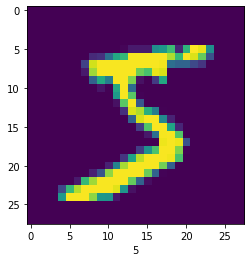

In [2]:
import matplotlib.pyplot as plt

sample_img, sample_label = train_dataset[0]
sample_img = sample_img.detach().cpu().numpy()
sample_img = sample_img.reshape([28, 28])
plt.imshow(sample_img)
plt.xlabel(str(sample_label))
plt.show()

In [3]:
from torch.utils.data import DataLoader

dataloader_args = dict(
  batch_size=128
)
train_dataloader = DataLoader(train_dataset,**dataloader_args)
test_dataloader = DataLoader(test_dataset, **dataloader_args)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNISTBaseline(nn.Module):
  def __init__(self):
    super(MNISTBaseline, self).__init__()

    self.backbone = nn.Sequential(
      nn.Conv2d(1, 16, 3, 1, bias=False),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(3, 2),
      nn.Conv2d(16, 32, 3, 1, bias=False),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(3, 2),
      nn.Dropout(0.1),
    )

    self.fc1 = nn.Linear(512, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.backbone(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


model = MNISTBaseline()
sample_x, sample_y = next(iter(train_dataloader))
x = model(sample_x)
print(x.shape)

torch.Size([128, 10])


In [5]:
from torch.optim import AdamW

class MNISTTrainer(object):
  def __init__(self, **kwargs):
    self.__dict__ = dict(kwargs)

    self.model = self.model.to(self.device)
    self.optimizer = AdamW(model.parameters(), lr=1e-3)
    self.loss_fn = nn.CrossEntropyLoss()

  def train_step(self):
    device = self.device
    for x, y in self.train_dataloader:
      x, y = x.to(device), y.to(device)
      self.optimizer.zero_grad()
      output = model(x)
      loss = self.loss_fn(output, y)
      loss.backward()
      self.optimizer.step()

  def train(self):
    self.model.train()
    for epoch in range(self.epochs):
      self.train_step()
      self.evaluate()

  def evaluate(self):
    self.model.eval()
    test_loss = 0
    correct = 0

    device = self.device
    with torch.no_grad():
      for x, y in self.test_dataloader:
        x, y = x.to(device), y.to(device)
        p = self.model(x)
        test_loss += self.loss_fn(p, y).item()
        p = p.argmax(dim=1, keepdim=True)
        correct += p.eq(y.view_as(p)).sum().item()

    datasize = len(self.test_dataloader.dataset)
    test_loss /= datasize
    print(f'Test: Average loss: {test_loss}, Accuracy: {correct}/{datasize} ({100. * correct / datasize}%)')


trainer_args = dict(
  epochs=10,
  model=model,
  train_dataloader=train_dataloader,
  test_dataloader=test_dataloader,
  device='cuda'
)
trainer = MNISTTrainer(**trainer_args)
trainer.train()

Test: Average loss: 0.00047813493837602436, Accuracy: 9811/10000 (98.11%)
Test: Average loss: 0.00042925924734736327, Accuracy: 9835/10000 (98.35%)
Test: Average loss: 0.00041891066540265457, Accuracy: 9828/10000 (98.28%)
Test: Average loss: 0.0003605841745840735, Accuracy: 9852/10000 (98.52%)
Test: Average loss: 0.00034857125919515963, Accuracy: 9862/10000 (98.62%)
Test: Average loss: 0.00037776408895770145, Accuracy: 9860/10000 (98.6%)
Test: Average loss: 0.0003587615905991697, Accuracy: 9861/10000 (98.61%)
Test: Average loss: 0.00038126383808885294, Accuracy: 9848/10000 (98.48%)
Test: Average loss: 0.00037816400647593584, Accuracy: 9857/10000 (98.57%)
Test: Average loss: 0.0003905221735081568, Accuracy: 9855/10000 (98.55%)


## Step 2: Converting the model to ONNX format
Once you've trained your model, you can convert it to ONNX format using the torch.onnx.export() function.
This function takes your trained PyTorch model, some example inputs, and a filename for the output ONNX file.

In [6]:
model.eval()
x = torch.randn(1, 1, 28, 28, requires_grad=True)
x = x.to('cuda')
output = model(x)

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "mnist.onnx",              # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

## Step 3: Converting the ONNX model to a C file using ONNX2C
Finally, you can use ONNX2C to convert your ONNX model to a C file. ONNX2C is a tool that allows you to compile your ONNX model to a C implementation

https://github.com/kraiskil/onnx2c

In [7]:
!$HOME/projects/onnx2c/build/onnx2c $HOME/projects/model-zoo/notebooks/mnist.onnx -d batch_size:1 > mnist.c

## CIFAR100 example

In [8]:
from torchvision.datasets import CIFAR100
import torchvision.transforms as T

transform = T.Compose([
  T.ToTensor(),
])

root = os.path.join(os.getenv('HOME'), 'datasets', 'cifar100')
train_dataset = CIFAR100(root, train=True, download=True, transform=transform)
test_dataset = CIFAR100(root, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
dataloader_args = dict(
  batch_size=1024
)
train_dataloader = DataLoader(train_dataset,**dataloader_args)
test_dataloader = DataLoader(test_dataset, **dataloader_args)

In [10]:
class CIFAR100Baseline(nn.Module):
  def __init__(self):
    super(CIFAR100Baseline, self).__init__()

    self.backbone = nn.Sequential(
      nn.Conv2d(3, 8, 3, 1, padding=1, bias=False),
      nn.BatchNorm2d(8),
      nn.ReLU(),
      nn.MaxPool2d(3, 2),  # 8x16x16
      nn.Conv2d(8, 16, 3, 1, padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(3, 2),  # 16x8x8
      nn.Conv2d(16, 32, 3, 1, padding=1, bias=False),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(3, 2),  # 32x4x4
      nn.Conv2d(32, 64, 3, 1, padding=1, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(3, 2),  # 64x2x2
      nn.Dropout(0.1),
    )
    self.fc = nn.Linear(64, 100)

  def forward(self, x):
    x = self.backbone(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x


model = CIFAR100Baseline()
sample_x, sample_y = next(iter(train_dataloader))
x = model(sample_x)

In [11]:
class CIFAR100Trainer(object):
  def __init__(self, **kwargs):
    self.__dict__ = dict(kwargs)

    self.model = self.model.to(self.device)
    self.optimizer = AdamW(model.parameters(), lr=1e-3)
    self.loss_fn = nn.CrossEntropyLoss()

  def train_step(self):
    device = self.device
    for x, y in self.train_dataloader:
      x, y = x.to(device), y.to(device)
      self.optimizer.zero_grad()
      output = model(x)
      loss = self.loss_fn(output, y)
      loss.backward()
      self.optimizer.step()

  def train(self):
    self.model.train()
    for epoch in range(self.epochs):
      self.train_step()
      self.evaluate()

  def evaluate(self):
    self.model.eval()
    test_loss = 0
    correct = 0

    device = self.device
    with torch.no_grad():
      for x, y in self.test_dataloader:
        x, y = x.to(device), y.to(device)
        p = self.model(x)
        test_loss += self.loss_fn(p, y).item()
        p = p.argmax(dim=1, keepdim=True)
        correct += p.eq(y.view_as(p)).sum().item()

    datasize = len(self.test_dataloader.dataset)
    test_loss /= datasize
    print(f'Test: Average loss: {test_loss}, Accuracy: {correct}/{datasize} ({100. * correct / datasize}%)')


trainer_args = dict(
  epochs=50,
  model=model,
  train_dataloader=train_dataloader,
  test_dataloader=test_dataloader,
  device='cuda'
)
trainer = CIFAR100Trainer(**trainer_args)
trainer.train()

Test: Average loss: 0.004196225023269653, Accuracy: 819/10000 (8.19%)
Test: Average loss: 0.0036710076570510863, Accuracy: 1489/10000 (14.89%)
Test: Average loss: 0.003498375129699707, Accuracy: 1778/10000 (17.78%)
Test: Average loss: 0.0033718328714370726, Accuracy: 1989/10000 (19.89%)
Test: Average loss: 0.003268707609176636, Accuracy: 2184/10000 (21.84%)
Test: Average loss: 0.003197568583488464, Accuracy: 2340/10000 (23.4%)
Test: Average loss: 0.003142877244949341, Accuracy: 2457/10000 (24.57%)
Test: Average loss: 0.003099172019958496, Accuracy: 2523/10000 (25.23%)
Test: Average loss: 0.003059906840324402, Accuracy: 2608/10000 (26.08%)
Test: Average loss: 0.0030236181974411013, Accuracy: 2667/10000 (26.67%)
Test: Average loss: 0.0029919612884521485, Accuracy: 2758/10000 (27.58%)
Test: Average loss: 0.0029636443138122558, Accuracy: 2816/10000 (28.16%)
Test: Average loss: 0.0029422213077545164, Accuracy: 2870/10000 (28.7%)
Test: Average loss: 0.0029274901151657103, Accuracy: 2894/1000

In [12]:
model.eval()
x = torch.randn(1, 3, 32, 32, requires_grad=True)
model.to('cpu')
output = model(x)

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "cifar100.onnx",           # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [13]:
!$HOME/projects/onnx2c/build/onnx2c $HOME/projects/model-zoo/notebooks/cifar100.onnx -d batch_size:1 > cifar100.c

## Caveat

RNN doesn't seem to be able to convert to onnx

- LSTMs
- GRU

## Conclusion

1. train the model
2. Convert to ONNX
3. run `./onnx2c model.onnx -d batch_size:1 > model.c`